# Offline Handwritten Character Recognition for Igbo Alphabet (CNN)

*```Author:```*    ```Adedoyin Simeon Adeyemi```

    *************************************************************
    Author:    ```Adedoyin Simeon Adeyemi```
    Date:        February, 2020
    *************************************************************

In [ ]:
# importing libraries and packages

In [ ]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline

import os, shutil
from os import listdir, path

# CNN keras libs
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout


#from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array



from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Visualizing Model Architecture
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import pydot

# loading saved cnn model
from keras.models import load_model
from keras.preprocessing import image


# Evaluation Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report

In [ ]:
# Connecting Google Colab to Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/My Drive/character_dataset.zip" -d "/content/gdrive/My Drive/Datasets/character_datasets"

Streaming output truncated to the last 5000 lines.
 extracting: /content/gdrive/My Drive/Datasets/character_datasets/character_dataset/categories/images/o/17739056.jpg  
 extracting: /content/gdrive/My Drive/Datasets/character_datasets/character_dataset/categories/images/o/38679305.jpg  
 extracting: /content/gdrive/My Drive/Datasets/character_datasets/character_dataset/categories/images/o/6358477.jpg  
 extracting: /content/gdrive/My Drive/Datasets/character_datasets/character_dataset/categories/images/o/26124016.jpg  
 extracting: /content/gdrive/My Drive/Datasets/character_datasets/character_dataset/categories/images/o/6403839.jpg  
 extracting: /content/gdrive/My Drive/Datasets/character_datasets/character_dataset/categories/images/o/19584851.jpg  
 extracting: /content/gdrive/My Drive/Datasets/character_datasets/character_dataset/categories/images/o/53768728.jpg  
 extracting: /content/gdrive/My Drive/Datasets/character_datasets/character_dataset/categories/images/o/9679665.jpg  


In [ ]:
# Setting Dataset Home Path on google drive

# NOTE:
# Change these two paths to point to where you saved the Dataset on your google drive
# Click the link that pops-up to authenticate with your google account to allow colab access your drive
# Copy the access code generated and past in the space provided in your google colab and press enter.
# Everything in the codes should now run fine
# I have shared the Dataset folder on my google drive with you.

origin_path = "/content/gdrive/MyDrive/Datasets/character_datasets/character_dataset/categories/images/"
dataset_path = "/content/gdrive/MyDrive/Datasets/character_datasets/character_dataset/categories/"
model_path = "/content/gdrive/MyDrive/Datasets/character_datasets/character_dataset/categories/models"

# Moving Files from original folder to approriate ones

## Creating Training Set

## Viewing images counts for each category

In [ ]:
def get_dataset_info(origin):
  class_categories = os.listdir(origin)
  class_categories.sort()

  cat_sizes = {}
  cat_sizes["categories"] = []
  cat_sizes["total_images"] = []
  cat_sizes["train_size"] = []  # 70% of total
  cat_sizes["val_size"] = []  # 20% of total
  cat_sizes["test_size"] = [] # 10% of total


  for folder in class_categories:
    total_images = len(os.listdir(origin + folder +"/"))

    val_size = int(0.20 * total_images)
    test_size = int(0.10 * total_images)
    train_size = total_images - (val_size + test_size)

    cat_sizes["categories"].append(folder)
    cat_sizes["total_images"].append(total_images)
    cat_sizes["train_size"].append(train_size)
    cat_sizes["val_size"].append(val_size)
    cat_sizes["test_size"].append(test_size)


  cat_sizes = pd.DataFrame(cat_sizes)
  print(f'Total Number of categories are: {len(cat_sizes)}')

  return cat_sizes


In [ ]:
ds_sizes = get_dataset_info(origin=origin_path)
ds_sizes.head()

Total Number of categories are: 36


categories  total_images  train_size  val_size  test_size
0          a           386         271        77         38
1          b           393         276        78         39
2         ch           395         277        79         39
3          d           465         326        93         46
4          e           539         379       107         53

# Copying files to appropriate train, validation and test sets

In [ ]:
def create_train_test_split(ds):
  """
    This function Split the images for each category into training, validation and test set
  """

  for i, folder in enumerate(ds.categories):
    src_files = os.listdir(origin_path + folder + "/")

    train_size = ds.iloc[i]["train_size"]
    valid_size = ds.iloc[i]["val_size"]
    test_size = ds.iloc[i]["test_size"]

    train_files = src_files[:train_size]
    valid_files = src_files[train_size: (train_size + valid_size)]
    test_files = src_files[(train_size + valid_size):]

    # Creating Training set
    for file in train_files:
      src = origin_path + folder + "/" + file
      dest = dataset_path + "train_set/" + folder

      # Create folder, if not already exists
      if not path.exists(dest):
        os.mkdir(dest)

      dest = dest + "/" + file.replace(' ', '')

      if (path.exists(src) and path.isfile(src)) and not path.exists(dest):
        shutil.copy(src, dest)

    # Creating Validation set
    for file in valid_files:
      src = origin_path + folder + "/" + file
      dest = dataset_path + "validation_set/" + folder

      # Create folder, if not already exists
      if not path.exists(dest):
        os.mkdir(dest)

      dest = dest + "/" + file.replace(' ', '')

      if (path.exists(src) and path.isfile(src)) and not path.exists(dest):
        shutil.copy(src, dest)

    # Creating Testing set
    for file in test_files:
      src = origin_path + folder + "/" + file
      dest = dataset_path + "test_set/" + folder

      # Create folder, if not already exists
      if not path.exists(dest):
        os.mkdir(dest)

      dest = dest + "/" + file.replace(' ', '')

      if (path.exists(src) and path.isfile(src)) and not path.exists(dest):
        shutil.copy(src, dest)

    print(f'Done splitting images for category "{folder}" ...')
  print("\n... Don splitting images for all categories...")

In [ ]:
create_train_test_split(ds=ds_sizes)
#os.mkdir(dataset_path + "ab")


Done splitting images for category "a" ...
Done splitting images for category "b" ...
Done splitting images for category "ch" ...
Done splitting images for category "d" ...
Done splitting images for category "e" ...
Done splitting images for category "f" ...
Done splitting images for category "g" ...
Done splitting images for category "gb" ...
Done splitting images for category "gh" ...
Done splitting images for category "gw" ...
Done splitting images for category "h" ...
Done splitting images for category "i" ...
Done splitting images for category "ị" ...
Done splitting images for category "j" ...
Done splitting images for category "k" ...
Done splitting images for category "kp" ...
Done splitting images for category "kw" ...
Done splitting images for category "l" ...
Done splitting images for category "m" ...
Done splitting images for category "n" ...
Done splitting images for category "nw" ...
Done splitting images for category "ny" ...
Done splitting images for category "ṅ" ...
D

# ==================================================
# CNN CODES BEGINS FROM HERE
# ==================================================

In [ ]:
# del cnn_model4
# del model5

# Model Configuration 1 (Adam Optimizer @64x64x3)

In [ ]:
# Initializing the CNN
cnn_model4 = Sequential()

# Adding the Convolution Layers
cnn_model4.add(Conv2D(filters=64, kernel_size=(5,5),
                          input_shape=(64,64,3), activation='relu'))
cnn_model4.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
# Adding the Maxpooling Layer
cnn_model4.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Adding Convolution Layers
cnn_model4.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu'))
cnn_model4.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu'))
# Adding Maxpooling Layer
cnn_model4.add(MaxPool2D(pool_size=(2,2)))

# Adding Convolution Layers
cnn_model4.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
cnn_model4.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
# Adding Maxpooling Layer
cnn_model4.add(MaxPool2D(pool_size=(2,2)))

# # Adding Convolution Layers
# cnn_model4.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
# cnn_model4.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
# # Adding Maxpooling Layer
# cnn_model4.add(MaxPool2D(pool_size=(2,2)))

# Step 3: Adding the Flatten Layer and then to Fully_connected ANN
cnn_model4.add(Flatten())
cnn_model4.add(Dense(units=512, activation='relu'))
cnn_model4.add(Dense(units=128, activation='relu'))
cnn_model4.add(Dense(units=64, activation='relu'))

cnn_model4.add(Dense(units=36, activation='softmax')) # output layer

# Configuring optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0) # Root Mean Squared Optimizer with default values
# Note:
      # * Could have used Stochastic Gradient Descent ('sgd') optimizer instead but it is slow, and RMSprop is simple and faster
      # * 'adam' is another optimizer. An improvement of 'sgd' optimizer

# Compile the cnn_model2
cnn_model4.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Alternative Configuration for Multi-lable case
# cnn_model1\2.add(Dense(units=3, activation='sigmoid')) # output layer
# cnn_model2.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])


# Model Configuration 2 (VGG19 with Adam @128x128x3 Input Image)

In [ ]:

base_model = VGG19(include_top=False, input_shape=(128,128, 3))
base_model.trainable = False

model5 = Sequential()
model5.add(base_model)
model5.add(Flatten())
# model5.summary()
model5.add(Dense(512, activation=('relu')))
model5.add(Dense(256, activation=('relu')))
model5.add(Dense(64, activation=('relu')))
model5.add(Dropout(.2))

# Final Layer
model5.add(Dense(units=36, activation=('softmax')))

model_checkpoint_file_path = model_path + "/character_recog_vgg19_model"

model_checkpoint_callback = ModelCheckpoint(filepath=model_checkpoint_file_path,
                                            save_weights_only=False, monitor='val_accuracy',
                                            mode='max', save_best_only=True
                                            )


adam = Adam(learning_rate=0.001)

model5.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

print(f'Model Input Shape: {model5.input_shape}\n')
print(f'Model Output Shape: {model5.output_shape}\n')

Model Input Shape: (None, 128, 128, 3)

Model Output Shape: (None, 36)



# Model Architectures

# Architecture for Model 1 (RMSProp @64x64x3 input)

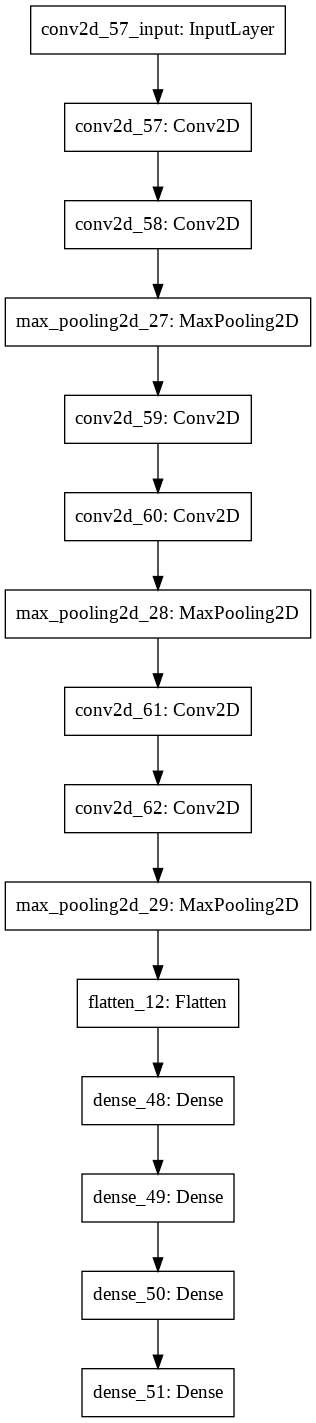

In [ ]:

plot_model(model=cnn_model4, to_file=model_path + '/character_recognition_model_config4_RMSProp_Architecture_1st.png')

In [ ]:
# Summary

cnn_model4.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 60, 60, 64)        4864      
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 56, 56, 64)        102464    
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 20, 20, 128)       409728    
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 8, 8, 256)       

# Architecture for Model 2  (Transfer Learning from VGG19, with Adam @128x128x3)

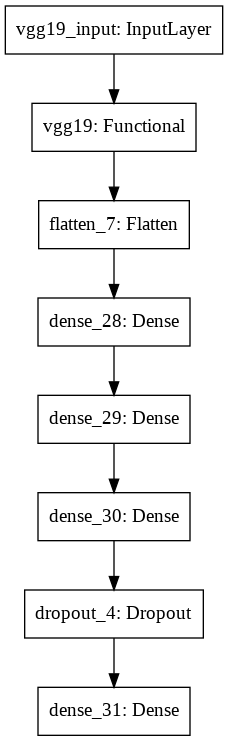

In [ ]:

plot_model(model=model5, to_file=model_path + '/character_recognition_vgg19_model_Adam_Architecture.png')

In [ ]:
model5.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dense_29 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_30 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 36)              

# Image Preprocessing - Augmentation (Generation)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.1,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,  # randomly flip images
                                   featurewise_center=False,  # set input mean to 0 over the dataset
                                   samplewise_center=False,  # set each sample mean to 0
                                   featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                   samplewise_std_normalization=False,  # divide each input by its std
                                   zca_whitening=False,  # apply ZCA whitening
                                   rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                                   width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                                   height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                                   )


validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
print("Categories...\n")
print(f"Size: {len(listdir(dataset_path + '/train_set'))}\n")
print(listdir(dataset_path + '/train_set'))


Categories...

Size: 36

['a', 'b', 'ch', 'd', 'e', 'f', 'g', 'gb', 'gh', 'gw', 'h', 'i', 'ị', 'j', 'k', 'kp', 'kw', 'l', 'm', 'n', 'nw', 'ny', 'ṅ', 'o', 'ọ', 'p', 'r', 's', 'sh', 't', 'u', 'ụ', 'v', 'w', 'y', 'z']


# Image Data Augmentations for Model 1

In [ ]:
training_set_aug_images_conf3 = train_datagen.flow_from_directory(
                                            dataset_path + '/train_set',
                                            target_size=(64,64),
                                            batch_size=32,
                                            class_mode='categorical')

validation_set_aug_images_conf3 = validation_datagen.flow_from_directory(
                                            dataset_path + '/validation_set',
                                            target_size=(64,64),
                                            batch_size=32,
                                            class_mode='categorical')

testing_set_aug_images_conf3 = test_datagen.flow_from_directory(
                                            dataset_path + '/test_set',
                                            target_size=(64,64),
                                            batch_size=32,
                                            class_mode='categorical')

Found 12669 images belonging to 36 classes.
Found 3597 images belonging to 36 classes.
Found 1780 images belonging to 36 classes.


# Image Data Augmententation for Model 2

In [ ]:
# Generating the training and test data sets
# NOTE: 'target_size' should match the 'input_shape' of the convolution layer

training_set_aug_images = train_datagen.flow_from_directory(
                                            dataset_path + '/train_set',
                                            target_size=(128,128),
                                            batch_size=32,
                                            class_mode='categorical')

validation_set_aug_images = validation_datagen.flow_from_directory(
                                            dataset_path + '/validation_set',
                                            target_size=(128,128),
                                            batch_size=32,
                                            class_mode='categorical')

testing_set_aug_images = test_datagen.flow_from_directory(
                                            dataset_path + '/test_set',
                                            target_size=(128,128),
                                            batch_size=32,
                                            class_mode='categorical')


Found 12669 images belonging to 36 classes.
Found 3597 images belonging to 36 classes.
Found 1780 images belonging to 36 classes.


In [ ]:
total_Samples = len(training_set_aug_images.labels) + len(validation_set_aug_images.labels) + len(testing_set_aug_images.labels)
perc_train = np.round((len(training_set_aug_images.labels) / total_Samples) * 100)
perc_valid = np.round((len(validation_set_aug_images.labels) / total_Samples) * 100)
perc_test = np.round((len(testing_set_aug_images.labels) / total_Samples) * 100)

print(f'Total Training Sample: {len(training_set_aug_images.labels)}, \t Percentage: {perc_train}%')
print(f'Total Validation Sample: {len(validation_set_aug_images.labels)}, \t Percentage: {perc_valid}%')
print(f'Total Testing Sample: {len(testing_set_aug_images.labels)}, \t Percentage: {perc_test}%')

Total Training Sample: 12669, 	 Percentage: 70.0%
Total Validation Sample: 3597, 	 Percentage: 20.0%
Total Testing Sample: 1780, 	 Percentage: 10.0%


# Training the Models

## Note:
* I used a small size of epochs (15) because i used a CPU and this actually took up to 6 hours
* For improved predictive accuracy, the number of epochs should be set to around (100 to 150) so the model can learn more
* Use a GPU System</b> <br />


<b>ReduceLROnPlateau():</b> <br />
In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs. <br /> <br />

<b>EarlyStopping():</b> <br />
In order to reduce (optimize) computational resources, i used an early-stopping mechanism to stop the learning if the validation-loss is not reduced after 5 rounds, at which point it can be assumed the model is no more learning. This can also help prevent over-fitting.

In [ ]:
# NOTE: We only use 15 epochs during the training because of our limited CPU performance limitation. We are confident
# that the model will perform more excellently with more epochs on a GPU.

N_EPOCHS = 15
BATCH_SIZE = 32

In [ ]:
# Note: if error, replace 'val_accuracy' with 'val_acc'
# Seting a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

# Setting an Early Stopper in case model "loss" does not change over many epochs
early_stopper = EarlyStopping(monitor='loss', min_delta=0,
                             patience=3, verbose=1, mode='auto')

In [ ]:
history = cnn_model4.fit_generator(generator=training_set_aug_images_conf3,
                                    epochs=N_EPOCHS,
                                    steps_per_epoch=int(0.75 * len(training_set_aug_images_conf3.labels) / BATCH_SIZE),
                                    validation_data=validation_set_aug_images_conf3,
                                    validation_steps=int(0.15 * len(validation_set_aug_images_conf3.labels) / BATCH_SIZE),
                                    callbacks=[early_stopper, learning_rate_reduction]
                                    )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
296/296 [==============================] - 27s 92ms/step - loss: 0.5200 - accuracy: 0.8468 - val_loss: 0.3988 - val_accuracy: 0.8984
Epoch 2/15
296/296 [==============================] - 27s 91ms/step - loss: 0.4946 - accuracy: 0.8549 - val_loss: 0.3684 - val_accuracy: 0.8887
Epoch 3/15
296/296 [==============================] - 27s 92ms/step - loss: 0.4779 - accuracy: 0.8613 - val_loss: 0.4951 - val_accuracy: 0.8770
Epoch 4/15
296/296 [==============================] - 27s 91ms/step - loss: 0.4794 - accuracy: 0.8624 - val_loss: 0.3949 - val_accuracy: 0.9180
Epoch 5/15
296/296 [==============================] - 27s 92ms/step - loss: 0.4695 - accuracy: 0.8649 - val_loss: 0.4125 - val_accuracy: 0.8926
Epoch 6/15
296/296 [==============================] - 27s 92ms/step - loss: 0.4625 - accuracy: 0.8673 - val_loss: 0.3446 - val_accuracy: 0.9102
Epoch 7/15
296/296 [==============================] - 27s 92ms/step - loss: 0.4565 - accuracy: 0.8675 - val_loss: 0.4447 - val_accuracy:

In [ ]:
history5 = model5.fit_generator(generator=training_set_aug_images,
                                epochs=N_EPOCHS,
                                steps_per_epoch=int(0.75 * len(training_set_aug_images.labels) / BATCH_SIZE),
                                #steps_per_epoch=100,
                                validation_data=validation_set_aug_images,
                                validation_steps=len(validation_set_aug_images.labels),
                                #callbacks=[model_checkpoint_callback],
                                callbacks=[early_stopper, learning_rate_reduction]
                                )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
296/296 [==============================] - 55s 187ms/step - loss: 0.4959 - accuracy: 0.8530 - val_loss: 0.3403 - val_accuracy: 0.8991
Epoch 2/15
296/296 [==============================] - 54s 184ms/step - loss: 0.4664 - accuracy: 0.8555 - val_loss: 0.2951 - val_accuracy: 0.9208
Epoch 3/15
296/296 [==============================] - 55s 184ms/step - loss: 0.4489 - accuracy: 0.8629 - val_loss: 0.3500 - val_accuracy: 0.8969
Epoch 4/15
296/296 [==============================] - 54s 183ms/step - loss: 0.4403 - accuracy: 0.8638 - val_loss: 0.2553 - val_accuracy: 0.9269
Epoch 5/15
296/296 [==============================] - 55s 185ms/step - loss: 0.4502 - accuracy: 0.8639 - val_loss: 0.3219 - val_accuracy: 0.9063
Epoch 6/15
296/296 [==============================] - 55s 186ms/step - loss: 0.4294 - accuracy: 0.8673 - val_loss: 0.2659 - val_accuracy: 0.9233
Epoch 7/15
296/296 [==============================] - 55s 186ms/step - loss: 0.4230 - accuracy: 0.8712 - val_loss: 0.2847 - val_ac

## Summary of the Training Result

In [ ]:
# Details of the Training
model_config1_training_info = pd.DataFrame(history.history) # cnn_model4
model_config2_training_info = pd.DataFrame(history5.history) # model5


In [ ]:
# model with Configuration 1 (adams optimizer)
print('Model Config 1 Training Summary.\n')
model_config1_training_info

Model Config 1 Training Summary.



loss  accuracy  val_loss  val_accuracy     lr
0   0.520043  0.846763  0.398802      0.898438  0.001
1   0.494578  0.854941  0.368438      0.888672  0.001
2   0.477915  0.861337  0.495095      0.876953  0.001
3   0.479435  0.862393  0.394923      0.917969  0.001
4   0.469516  0.864928  0.412483      0.892578  0.001
5   0.462475  0.867293  0.344624      0.910156  0.001
6   0.456491  0.867462  0.444689      0.859375  0.001
7   0.442667  0.873271  0.317722      0.916016  0.001
8   0.439797  0.874789  0.478478      0.855469  0.001
9   0.447565  0.876861  0.337254      0.916016  0.001
10  0.454817  0.874116  0.536169      0.892578  0.001
11  0.475680  0.873587  0.299537      0.910156  0.001

In [ ]:
# model with Configuration 2 (RMSprop() [Root Mean Squared] optimizer)
print('Model Config 2 Training Summary.\n')
model_config2_training_info

Model Config 2 Training Summary.



loss  accuracy  val_loss  val_accuracy     lr
0   0.495864  0.852994  0.340321      0.899083  0.001
1   0.466408  0.855529  0.295130      0.920767  0.001
2   0.448929  0.862921  0.350017      0.896859  0.001
3   0.440310  0.863809  0.255275      0.926884  0.001
4   0.450158  0.863872  0.321928      0.906311  0.001
5   0.429405  0.867251  0.265894      0.923269  0.001
6   0.423037  0.871159  0.284673      0.924937  0.001
7   0.441658  0.864654  0.276023      0.921601  0.001
8   0.410078  0.872994  0.291315      0.919933  0.001
9   0.407088  0.875739  0.273772      0.924381  0.001
10  0.416014  0.872531  0.358414      0.906867  0.001
11  0.404962  0.875845  0.314764      0.909925  0.001
12  0.395195  0.879185  0.290766      0.914373  0.001
13  0.390028  0.876267  0.290564      0.917431  0.001
14  0.378739  0.882881  0.314461      0.919655  0.001

In [ ]:
print("FINAL TRAINING RESULT OF THE TWO  MODELS' CONFIGURATIONS")
print('************************************************************\n')
print(f"Model 1 (adam Optim. @64x64x3 Input shape): \t\t\t  after {len(model_config1_training_info)} epochs :\t Validation_Accuracy = {np.round(max(model_config1_training_info['val_accuracy']) * 100, 2)}%")
print(f"Model 2 (VGG19 + RMSprop Optim. @128x128x3 Input shape): \t  after {len(model_config2_training_info)} epochs :\t Validation_Accuracy = {np.round(max(model_config2_training_info['val_accuracy']) * 100, 2)}%")


FINAL TRAINING RESULT OF THE TWO  MODELS' CONFIGURATIONS
************************************************************

Model 1 (adam Optim. @64x64x3 Input shape): 			  after 12 epochs :	 Validation_Accuracy = 91.8%
Model 2 (VGG19 + RMSprop Optim. @128x128x3 Input shape): 	  after 15 epochs :	 Validation_Accuracy = 92.69%


# Evaluating Trained Models

In [ ]:
scores1 = cnn_model4.evaluate_generator(generator=testing_set_aug_images_conf3, steps=int(0.75 * len(testing_set_aug_images_conf3.labels) / BATCH_SIZE), verbose=2)
scores2 = model5.evaluate_generator(generator=testing_set_aug_images, steps=int(0.75 * len(testing_set_aug_images.labels) / BATCH_SIZE), verbose=2)

# Displaying Evaluation Result
print("\nSCORES OF EVALUATING TEST SET ON EACH THE MODELS")
print('-------------------------------------------------\n')
print(f"Evaluation of model 1 with Config 1: \t\t (loss = {np.round(scores1[0], 5)} \t accuracy = {np.round(scores1[1] * 100, 1)}%)")
print(f"Evaluation of model 2 with Config 2: \t\t (loss = {np.round(scores2[0], 5)} \t accuracy = {np.round(scores2[1] * 100, 1)}%)")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


41/41 - 2s - loss: 0.5890 - accuracy: 0.8270
41/41 - 2s - loss: 0.6099 - accuracy: 0.8613

SCORES OF EVALUATING TEST SET ON EACH THE MODELS
-------------------------------------------------

Evaluation of model 1 with Config 1: 		 (loss = 0.58901 	 accuracy = 82.7%)
Evaluation of model 2 with Config 2: 		 (loss = 0.60994 	 accuracy = 86.1%)


# Saving the Trained Models

In [ ]:
cnn_model4.save(model_path + '/model1_adam_64.h5')
model5.save(model_path + '/model2_vgg19_Transf_Learng_RMSprop_128.h5')

# VISUALIZING TRAINING RESULTS

## Model 1 Training

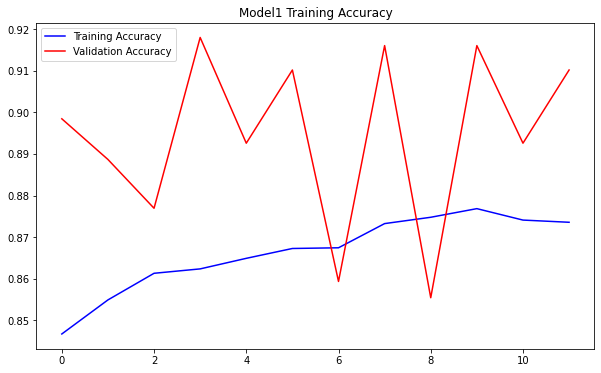

In [ ]:
# Model 1 Training Accuracy

plt.figure(figsize=(10,6))
plt.title("Model1 Training Accuracy")
plt.plot(model_config1_training_info["accuracy"], color='b', label="Training Accuracy")
plt.plot(model_config1_training_info["val_accuracy"], color='r', label="Validation Accuracy")
plt.legend()

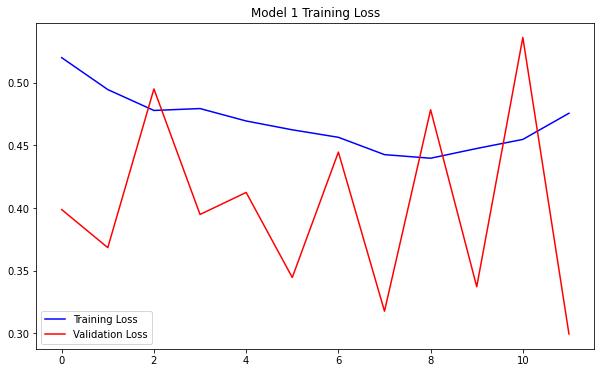

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Model 1 Training Loss")
plt.plot(model_config1_training_info["loss"], color='b', label="Training Loss")
plt.plot(model_config1_training_info["val_loss"], color='r', label="Validation Loss")
plt.legend()

Text(0, 0.5, 'Loss')

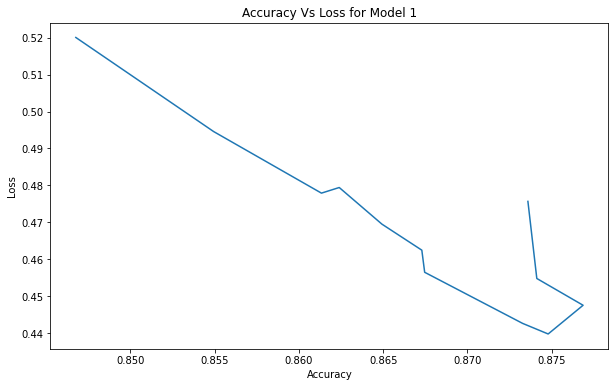

In [ ]:
# Loss Vs Accuracy

x_ticks = np.linspace(np.min(model_config1_training_info.loss) - 0.001,
                      np.max(model_config1_training_info.loss) + 0.001,
                      num=N_EPOCHS)

y_ticks = np.linspace(np.min(model_config1_training_info.accuracy) - 0.001,
                      np.max(model_config1_training_info.accuracy) + 0.001,
                      num=N_EPOCHS)

plt.figure(figsize=(10, 6))
plt.plot(model_config1_training_info.accuracy, model_config1_training_info.loss)
plt.x_ticks = x_ticks
plt.y_ticks = y_ticks
plt.title('Accuracy Vs Loss for Model 1')
plt.xlabel('Accuracy')
plt.ylabel('Loss')

## Model 2 Training

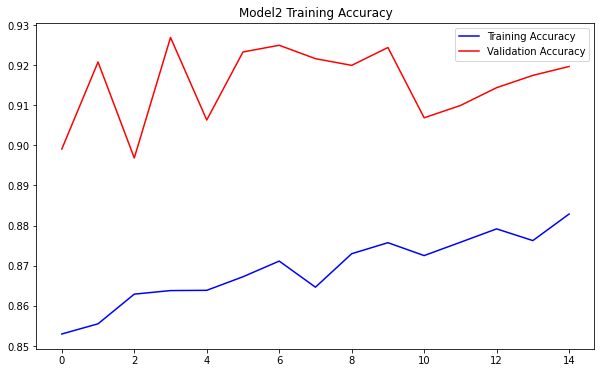

In [ ]:
# Model 2 Training Accuracy

plt.figure(figsize=(10,6))
plt.title("Model2 Training Accuracy")
plt.plot(model_config2_training_info["accuracy"], color='b', label="Training Accuracy")
plt.plot(model_config2_training_info["val_accuracy"], color='r', label="Validation Accuracy")
plt.legend()

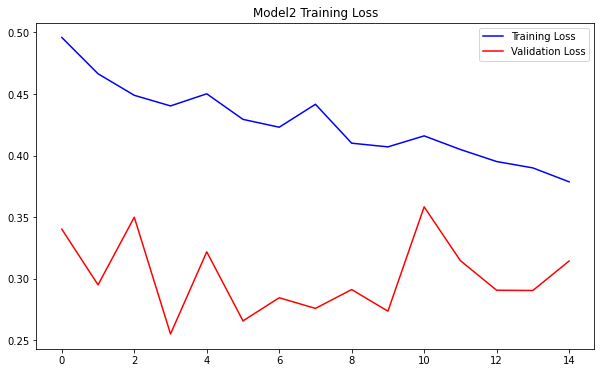

In [ ]:
# Model 2 Training Loss

plt.figure(figsize=(10,6))
plt.title("Model2 Training Loss")
plt.plot(model_config2_training_info["loss"], color='b', label="Training Loss")
plt.plot(model_config2_training_info["val_loss"], color='r', label="Validation Loss")
plt.legend()

Text(0, 0.5, 'Loss')

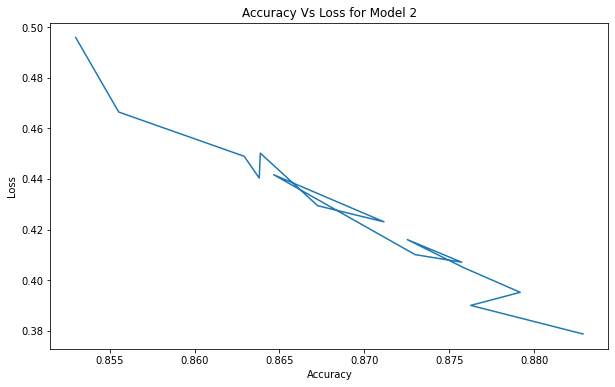

In [ ]:
# Loss Vs Accuracy

x_ticks = np.linspace(np.min(model_config2_training_info.loss) - 0.001,
                      np.max(model_config2_training_info.loss) + 0.001,
                      num=N_EPOCHS)

y_ticks = np.linspace(np.min(model_config2_training_info.accuracy) - 0.001,
                      np.max(model_config2_training_info.accuracy) + 0.001,
                      num=N_EPOCHS)

plt.figure(figsize=(10, 6))
plt.plot(model_config2_training_info.accuracy, model_config2_training_info.loss)
plt.x_ticks = x_ticks
plt.y_ticks = y_ticks
plt.title('Accuracy Vs Loss for Model 2')
plt.xlabel('Accuracy')
plt.ylabel('Loss')

# Loading Saved Models from Disk

In [ ]:
# cnn_model4.save(model_path + '/model1_adam_64.h5')
# model5.save(model_path + '/model2_vgg19_Transf_Learng_RMSprop_128.h5')

model1 = load_model(model_path + '/model1_adam_64.h5')
model2 = load_model(model_path + '/model2_vgg19_Transf_Learng_RMSprop_128.h5')


# Models Predictions and Evaluations

## Some Utility Functions

In [ ]:
def load_image(img_path, target_size=(128,128), show=False):
  img = image.load_img(img_path, target_size=target_size, color_mode='rgb')

  #(height,width,channels)
  img_tensor = image.img_to_array(img)

  #img_tensor = np.vstack([img_tensor])

  #(1,height,width,channels), adds a dim coz model expects shape: (batch_size,height,width,channels)
  img_tensor = np.expand_dims(img_tensor,axis=0)

  #imshow expects values in range[0,1]
  img_tensor = img_tensor / 255.

  if show:
    plt.imshow(img_tensor[0])
    plt.axis('off')
    plt.show()

  return img_tensor


def get_class_value(x):
  if type(x) == list:
    classes = []
    for label in x:
      label_name = list(training_set_aug_images.class_indices.keys())[label]
      classes.append(label_name)

    return classes

  else:
      return list(training_set_aug_images.class_indices.keys())[x]


def get_labels(paths):
  labels = []
  for path in paths:
    label_class = path.split("/")[-2]
    label_num = training_set_aug_images.class_indices[label_class]
    labels.append(label_num)

  return labels

def get_label(path):
  label_class = path.split("/")[-2]
  label_num = training_set_aug_images.class_indices[label_class]
  return label_num


In [ ]:
def predict(model, data, target_size=(128,128), kind='augumented', limit=0, show=False):
  """
  Predicts the class(es) of image(s) in 'data' using 'model' and returns a dictionary object.
  Arguments:
  ----------
  model (cnn model): A trained model to predict with
  data (str or augmented_image_obj): A file path or an augmented image object:
  kind (str):  Specifies the type of 'data' passed.
      Value:
      * Can be any of {'augumented' / 'single' / 'multiple'}, defaults to 'augumented'.
      * Set to 'single' if data is an image path,
      * set to 'multiple' if data is a list of images paths

  limit(int): The number of images to predict from given list of paths (< size of data)
  show (bool): Determines whether the Images should be shown (will always show if kind='single')

  """

  # Initialize predictions
  predictions = {'pred_labels':[],  'true_labels':[], 'pred_values':[],'true_values':[]}

  if kind == 'augumented':
    predictions = predict_from_aug_obj(model, data, target_size, limit, show=show)
  elif kind == 'single':
    predictions = predict_single(model, data, target_size)
  elif kind == 'multiple':
    predictions = predict_multiple(model, data, target_size, limit, show=show)

  return predictions


def predict_from_aug_obj(model, aug_img_set_obj, target_size=(128,128), limit=0, show=False):
  # result template
  #result = {'pred_labels':[], 'True_labels':true_lbls, 'pred_values':pred_vals, 'True_values':true_vals}
  pred_lbls = []
  pred_vals = []
  true_lbls = []
  true_vals = []

  if limit <= 0 or limit > len(aug_img_set_obj.filepaths):
    file_paths = aug_img_set_obj.filepaths
  else:
    t = aug_img_set_obj.filepaths.copy()
    np.random.shuffle(t)
    file_paths = list(np.random.choice(t, size=limit))

    #temp_images = list(np.random.choice(t, size=limit))
    # file_paths = aug_img_set_obj.filepaths[:limit]


  if show:
    rows = len(file_paths) // 5
    if len(file_paths) % 5 != 0:
      rows += 1

    plt.figure(num=len(file_paths), figsize=(20, 5 * rows))

  for i,img_path in enumerate(file_paths):
    # Converting the Image to array and predict
    new_image = load_image(img_path, target_size=target_size)
    predicted = model.predict_classes(new_image)

    # Showing Prediction details
    classes = [key for key in aug_img_set_obj.class_indices]
    #predicted_value = classes[predicted[0]]
    #actual_value = classes[aug_img_set_obj.labels[i]]
    predicted_value = get_class_value(predicted[0])
    actual_label = get_label(img_path)
    actual_value = get_class_value(actual_label)


    if show:
      img_data = plt.imread(img_path)
      plt.subplot(rows, 5, i+1)
      #ax[row, col].imshow(img_data)
      plt.imshow(img_data)
      #plt.title("Pred. :{} True :{}".format(predicted[0], aug_img_set_obj.labels[i]))
      plt.axis('off')
      plt.title("Predicted : {} ({}) \nActual : {} ({})".format(predicted[0],
                                                                predicted_value,
                                                                actual_label,
                                                                actual_value))

    # Add predicted label to predictions
    pred_lbls.append(predicted[0])
    pred_vals.append(predicted_value)
    true_lbls.append(actual_label)
    true_vals.append(actual_value)

  return {'pred_labels':pred_lbls, 'true_labels':true_lbls, 'pred_values':pred_vals, 'true_values':true_vals}


def predict_multiple(model, img_paths, target_size=(128,128), limit=0, show=False):
  pred_lbls = []
  pred_vals = []
  true_lbls = []
  true_vals = []

  if limit <= 0 or limit > len(img_paths):
    file_paths = img_paths
  else:
    file_paths = img_paths[:limit]

  if show:
    rows = len(file_paths) // 5
    if len(file_paths) % 5 != 0:
      rows += 1
    # Initialize plot to 20 width and (5 x rows) height (5 for each pix)
    plt.figure(num=len(file_paths), figsize=(20, 5 * rows))

  for i, path in enumerate(file_paths):
    new_image = load_image(path, target_size)
    predicted = model.predict_classes(new_image)
    predicted_value = get_class_value(predicted[0])

    actual_label = get_label(path)
    actual_value = get_class_value(actual_label)

    pred_lbls.append(predicted[0])
    pred_vals.append(predicted_value)
    true_lbls.append(actual_label)
    true_vals.append(actual_value)

    if show:
      # Show Image
      img_data = plt.imread(path)
      plt.subplot(rows, 5, i+1)
      plt.imshow(img_data)
      plt.axis('off')
      plt.title("Predicted : {} ({}) \nActual : {} ({})".format(predicted[0],
                                                                predicted_value,
                                                                actual_label,
                                                                actual_value))

  return {'pred_labels':pred_lbls, 'true_labels':true_lbls, 'pred_values':pred_vals, 'true_values':true_vals}


def predict_single(model, img_path, target_size=(128,128)):
  new_image = load_image(img_path, target_size)
  predicted = model.predict_classes(new_image)
  class_val = get_class_value(predicted[0])

  # actual_label = get_label(img_path)
  # actual_value = get_class_value(actual_label)

  # Show Image
  img_data = plt.imread(img_path)
  plt.imshow(img_data)
  plt.title(f'Pred.: {predicted[0]} ({class_val})')
  plt.axis('off')

  return {'pred_labels':[predicted[0]], 'true_labels':[], 'pred_values':[class_val], 'true_values':[]}


def predict_multiple_v2(model, data, target_size=(256,256), limit=0):
  pred_labels = []
  pred_values = []

  if limit <= 0 or limit > len(data):
    file_paths = data
  else:
    file_paths = data[:limit]

  for path in file_paths:
    result = predict_single(model, path, target_size)
    pred_labels.append(result["pred_labels"][0])
    pred_values.append([result["pred_values"][0]])

  return {'pred_labels':pred_labels, 'true_labels':[], 'pred_values':pred_values, 'true_values':[]}


# Evaluating the Trained Models Prediction with the Test Set

## Testset Data for Model 1 and Model 2

In [ ]:
# Loading Testing Set data for Model 1 and Model 2

# print(f'\nClass Indices: \n{testing_set_aug_images.class_indices}\n')
# print(f'True Labels: \n{testing_set_aug_images.labels}')

print(f"Total number of test images: {len(testing_set_aug_images.labels)} images\n")
dico = {'classes': list(testing_set_aug_images.class_indices.keys()), "codes": list(testing_set_aug_images.class_indices.values())}
pd.DataFrame(dico)

Total number of test images: 1780 images



classes  codes
0        a      0
1        b      1
2       ch      2
3        d      3
4        e      4
5        f      5
6        g      6
7       gb      7
8       gh      8
9       gw      9
10       h     10
11       i     11
12      ị     12
13       j     13
14       k     14
15      kp     15
16      kw     16
17       l     17
18       m     18
19       n     19
20      nw     20
21      ny     21
22      ṅ     22
23       o     23
24      ọ     24
25       p     25
26       r     26
27       s     27
28      sh     28
29       t     29
30       u     30
31      ụ     31
32       v     32
33       w     33
34       y     34
35       z     35

In [ ]:
scores1 = model1.evaluate_generator(generator=testing_set_aug_images_conf3, steps=int(0.75 * len(testing_set_aug_images_conf3.labels) / BATCH_SIZE), verbose=2)
scores2 = model2.evaluate_generator(generator=testing_set_aug_images, steps=int(0.75 * len(testing_set_aug_images.labels) / BATCH_SIZE), verbose=2)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


41/41 - 2s - loss: 0.5398 - accuracy: 0.8422
41/41 - 2s - loss: 0.6155 - accuracy: 0.8598


In [ ]:
# Displaying Evaluation Result
print("SCORES OF EVALUATING TEST SET ON EACH OF THE MODELS")
print('-------------------------------------------------\n')
print(f"Evaluation of model 1 with Config 1: \t\t (loss = {np.round(scores1[0], 5)} \t\t accuracy = {np.round(scores1[1] * 100, 1)}%)")
print(f"Evaluation of model 2 with Config 2: \t\t (loss = {np.round(scores2[0], 5)} \t\t accuracy = {np.round(scores2[1] * 100, 1)}%)")

SCORES OF EVALUATING TEST SET ON EACH OF THE MODELS
-------------------------------------------------

Evaluation of model 1 with Config 1: 		 (loss = 0.53984 		 accuracy = 84.2%)
Evaluation of model 2 with Config 2: 		 (loss = 0.61551 		 accuracy = 86.0%)


# Predictions Made from the Test Set

In [ ]:
pred_test_model1 = predict(model=model1, data=testing_set_aug_images_conf3, target_size=(64,64), kind='augumented', limit=0, show=False)
pred_test_model2 = predict(model=model2, data=testing_set_aug_images, target_size=(128,128), kind='augumented', limit=0, show=False)\

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


## Model 1 Predictions

In [ ]:
# Top 15 Predictions made by Model 1

y_pred_test_model1 = pd.DataFrame(pred_test_model1)
y_pred_test_model1.head(15)

pred_labels  true_labels pred_values true_values
0             0            0           a           a
1             0            0           a           a
2             0            0           a           a
3            23            0           o           a
4             0            0           a           a
5             0            0           a           a
6             0            0           a           a
7             0            0           a           a
8            23            0           o           a
9             0            0           a           a
10            0            0           a           a
11            4            0           e           a
12            0            0           a           a
13            0            0           a           a
14            0            0           a           a

In [ ]:
# Last 15 Predictions made by Model 1

y_pred_test_model1.tail(15)

pred_labels  true_labels pred_values true_values
1765           35           35           z           z
1766           35           35           z           z
1767           35           35           z           z
1768           35           35           z           z
1769           35           35           z           z
1770           35           35           z           z
1771           35           35           z           z
1772           35           35           z           z
1773           27           35           s           z
1774           35           35           z           z
1775           35           35           z           z
1776           13           35           j           z
1777            5           35           f           z
1778           35           35           z           z
1779           35           35           z           z

## Model 2 Predictions

In [ ]:
# Top 15 Predictions made by Model 2

y_pred_test_model2 = pd.DataFrame(pred_test_model2)
y_pred_test_model2.head(15)

pred_labels  true_labels pred_values true_values
0             0            0           a           a
1             0            0           a           a
2             0            0           a           a
3            27            0           s           a
4             0            0           a           a
5            23            0           o           a
6            24            0          ọ           a
7             0            0           a           a
8             0            0           a           a
9             0            0           a           a
10            0            0           a           a
11           23            0           o           a
12            0            0           a           a
13           27            0           s           a
14            0            0           a           a

In [ ]:
# Top 15 Predictions made by Model 2

y_pred_test_model2.tail(15)

pred_labels  true_labels pred_values true_values
1765           35           35           z           z
1766           35           35           z           z
1767           35           35           z           z
1768           35           35           z           z
1769           35           35           z           z
1770           35           35           z           z
1771           35           35           z           z
1772           35           35           z           z
1773           35           35           z           z
1774           35           35           z           z
1775           35           35           z           z
1776           35           35           z           z
1777           35           35           z           z
1778           35           35           z           z
1779           35           35           z           z

# Performance Evaluation of Each Model

## Model 1 Performances

In [ ]:
# Classification Report

print("\n")
print("\t\tClassification Report for Model 1")
print("\t\t----------------------------------\n")

print(classification_report(y_pred_test_model1.true_labels, y_pred_test_model1.pred_labels))




		Classification Report for Model 1
		----------------------------------

              precision    recall  f1-score   support

           0       0.63      0.78      0.70        37
           1       0.41      0.54      0.47        39
           2       0.82      0.92      0.87        39
           3       0.35      0.24      0.29        46
           4       0.63      0.83      0.72        53
           5       0.92      0.83      0.87        53
           6       0.88      0.51      0.65        43
           7       0.96      0.76      0.85        29
           8       0.89      0.80      0.84        20
           9       0.95      0.95      0.95        20
          10       0.76      0.89      0.82        36
          11       0.86      0.67      0.75        27
          12       1.00      0.94      0.97        36
          13       0.70      0.84      0.76        62
          14       0.85      0.85      0.85        71
          15       0.95      0.91      0.93        57
     

Text(114.0, 0.5, 'True Label')

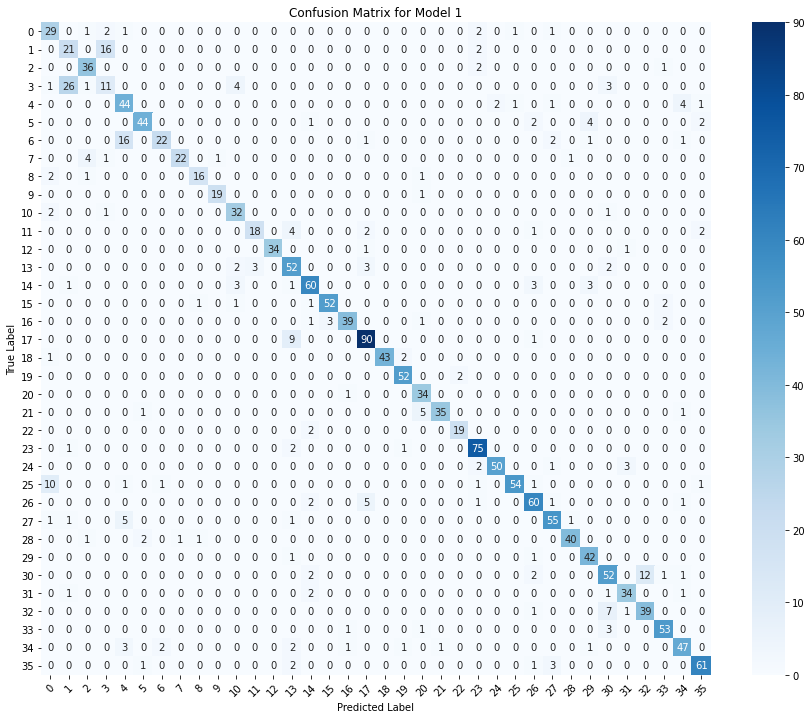

In [ ]:
# Confusion Matrix

conf_mat = confusion_matrix(y_pred_test_model1.true_labels, y_pred_test_model1.pred_labels)
plt.figure(figsize=(15, 12))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Model 1")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")


In [ ]:
print("Evaluation Metrics (Model 1)")
print('----------------------------\n')
print('Accuracy: \t', np.round(accuracy_score(y_pred_test_model1.true_labels, y_pred_test_model1.pred_labels), 3))
print('Recall: \t', np.round(recall_score(y_pred_test_model1.true_labels, y_pred_test_model1.pred_labels, average="weighted"), 3))
print('Precision: \t', np.round(precision_score(y_pred_test_model1.true_labels, y_pred_test_model1.pred_labels, average="weighted"), 3))
print('F1-Score: \t', np.round(f1_score(y_pred_test_model1.true_labels, y_pred_test_model1.pred_labels, average="weighted"), 3))
#print('ROC_AUC: \t', roc_auc_score(y_pred_test_model1.true_labels, y_pred_test_model1.pred_labels, multi_class='ovo'))


Evaluation Metrics (Model 1)
----------------------------

Accuracy: 	 0.835
Recall: 	 0.835
Precision: 	 0.842
F1-Score: 	 0.834


## Model 2 Performances

In [ ]:
# Classification Report

print("\n")
print("\t\tClassification Report for Model 2")
print("\t\t----------------------------------\n")

print(classification_report(y_pred_test_model2.true_labels, y_pred_test_model2.pred_labels))




		Classification Report for Model 2
		----------------------------------

              precision    recall  f1-score   support

           0       0.62      0.54      0.58        37
           1       0.65      0.56      0.60        39
           2       0.95      1.00      0.97        39
           3       0.73      0.70      0.71        46
           4       0.74      0.81      0.77        53
           5       1.00      0.89      0.94        53
           6       0.72      0.79      0.76        43
           7       0.59      0.83      0.69        29
           8       1.00      0.25      0.40        20
           9       0.76      0.80      0.78        20
          10       0.91      0.81      0.85        36
          11       0.90      0.67      0.77        27
          12       0.79      0.92      0.85        36
          13       0.89      0.77      0.83        62
          14       0.93      0.79      0.85        71
          15       0.98      0.91      0.95        57
     

Text(114.0, 0.5, 'True Label')

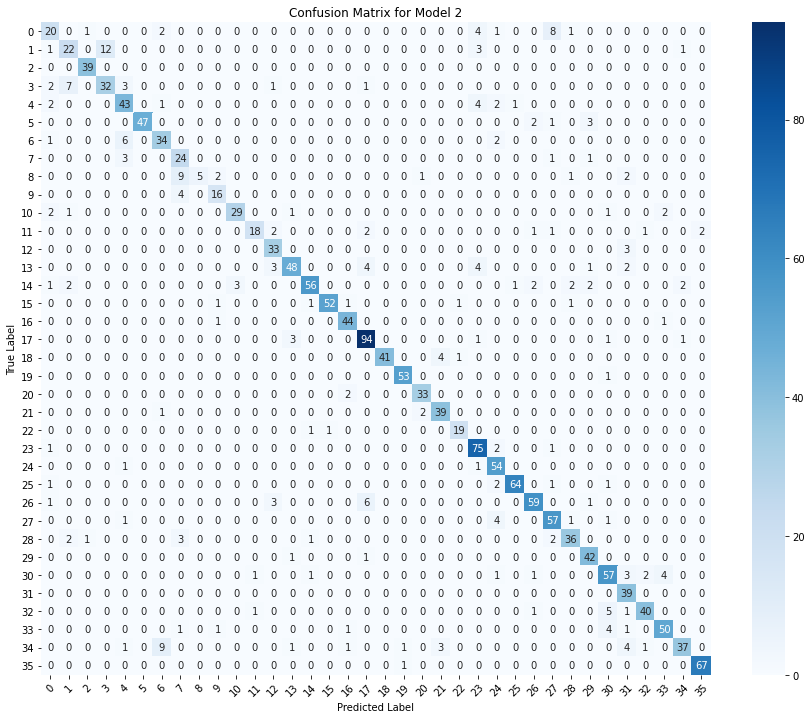

In [ ]:
# Confusion Matrix

conf_mat = confusion_matrix(y_pred_test_model2.true_labels, y_pred_test_model2.pred_labels)
plt.figure(figsize=(15, 12))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Model 2")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")


In [ ]:
print("Evaluation Metrics (Model 2)")
print('----------------------------\n')
print('Accuracy: \t', np.round(accuracy_score(y_pred_test_model2.true_labels, y_pred_test_model2.pred_labels), 3))
print('Recall: \t', np.round(recall_score(y_pred_test_model2.true_labels, y_pred_test_model2.pred_labels, average="weighted"), 3))
print('Precision: \t', np.round(precision_score(y_pred_test_model2.true_labels, y_pred_test_model2.pred_labels, average="weighted"), 3))
print('F1-Score: \t', np.round(f1_score(y_pred_test_model2.true_labels, y_pred_test_model2.pred_labels, average="weighted"), 3))
#print('ROC_AUC: \t', roc_auc_score(y_pred_test_model2.true_labels, y_pred_test_model2.pred_labels, multi_class='ovo'))


Evaluation Metrics (Model 2)
----------------------------

Accuracy: 	 0.853
Recall: 	 0.853
Precision: 	 0.86
F1-Score: 	 0.85


# Visualized Predictions

In [ ]:
temp_images = testing_set_aug_images.filepaths.copy()

print(f'Number of character images to test: \t {len(temp_images)}')


Number of character images to test: 	 1780


In [ ]:
# Shuffles the test set and randomly samples 30 images from there (So all categories will be represented)

np.random.shuffle(temp_images)
temp_images = list(np.random.choice(temp_images, size=20))

print(f'Number of character Images to test: \t {len(temp_images)}')

Number of character Images to test: 	 20


## Model 1 Evaluations

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



			********************************************************************************

			 RESULTS (MODEL 1)
			 -----------------

			 Accuracy: 	 80.0 %
			 Recall: 	 80.0 %
			 Precision: 	 85.0 %
			 F1-score: 	 82.0 %

			********************************************************************************






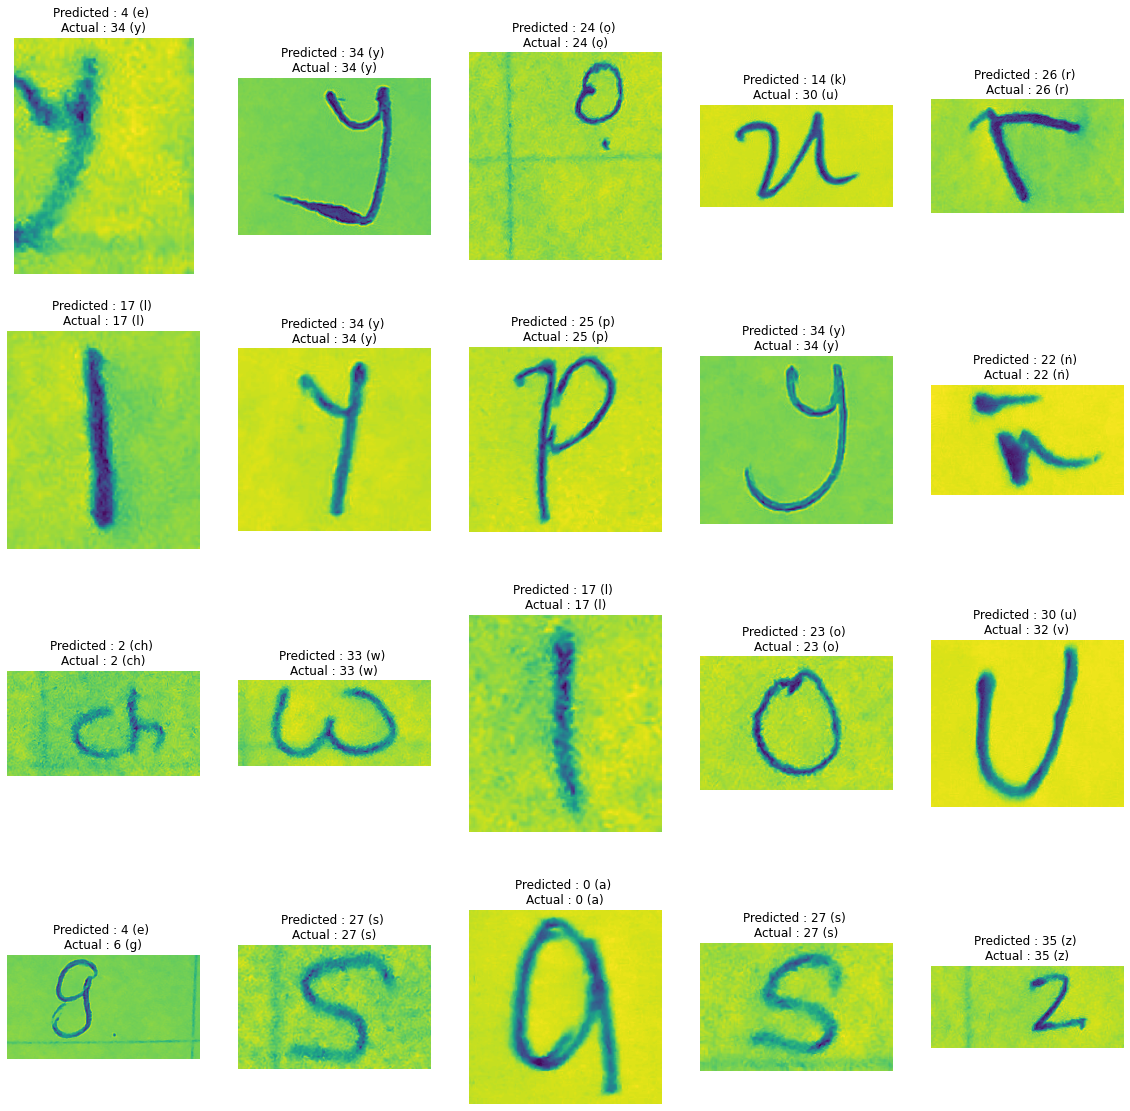

In [ ]:
pred = predict(model1, data=temp_images, target_size=(64,64), kind="multiple", limit=0, show=True)
pred = pd.DataFrame(pred)

print(f"\n\t\t\t{80 * '*'}\n")
print("\t\t\t RESULTS (MODEL 1)")
print("\t\t\t -----------------\n")
print(f"\t\t\t Accuracy: \t {np.round(accuracy_score(pred.true_labels, pred.pred_labels), 2) * 100} %")
print(f"\t\t\t Recall: \t {np.round(recall_score(pred.true_labels, pred.pred_labels, average='weighted', zero_division=0), 2) * 100} %")
print(f"\t\t\t Precision: \t {np.round(precision_score(pred.true_labels, pred.pred_labels, average='weighted',  zero_division=0), 2) * 100} %")
print(f"\t\t\t F1-score: \t {np.round(f1_score(pred.true_labels, pred.pred_labels, average='weighted'), 2) * 100} %")
print(f"\n\t\t\t{80 * '*'}\n")
print("\n\n")



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



			********************************************************************************

			 RESULTS (MODEL 1)
			 -----------------

			 Accuracy: 	 70.0 %
			 Recall: 	 70.0 %
			 Precision: 	 77.0 %
			 F1-score: 	 71.0 %

			********************************************************************************






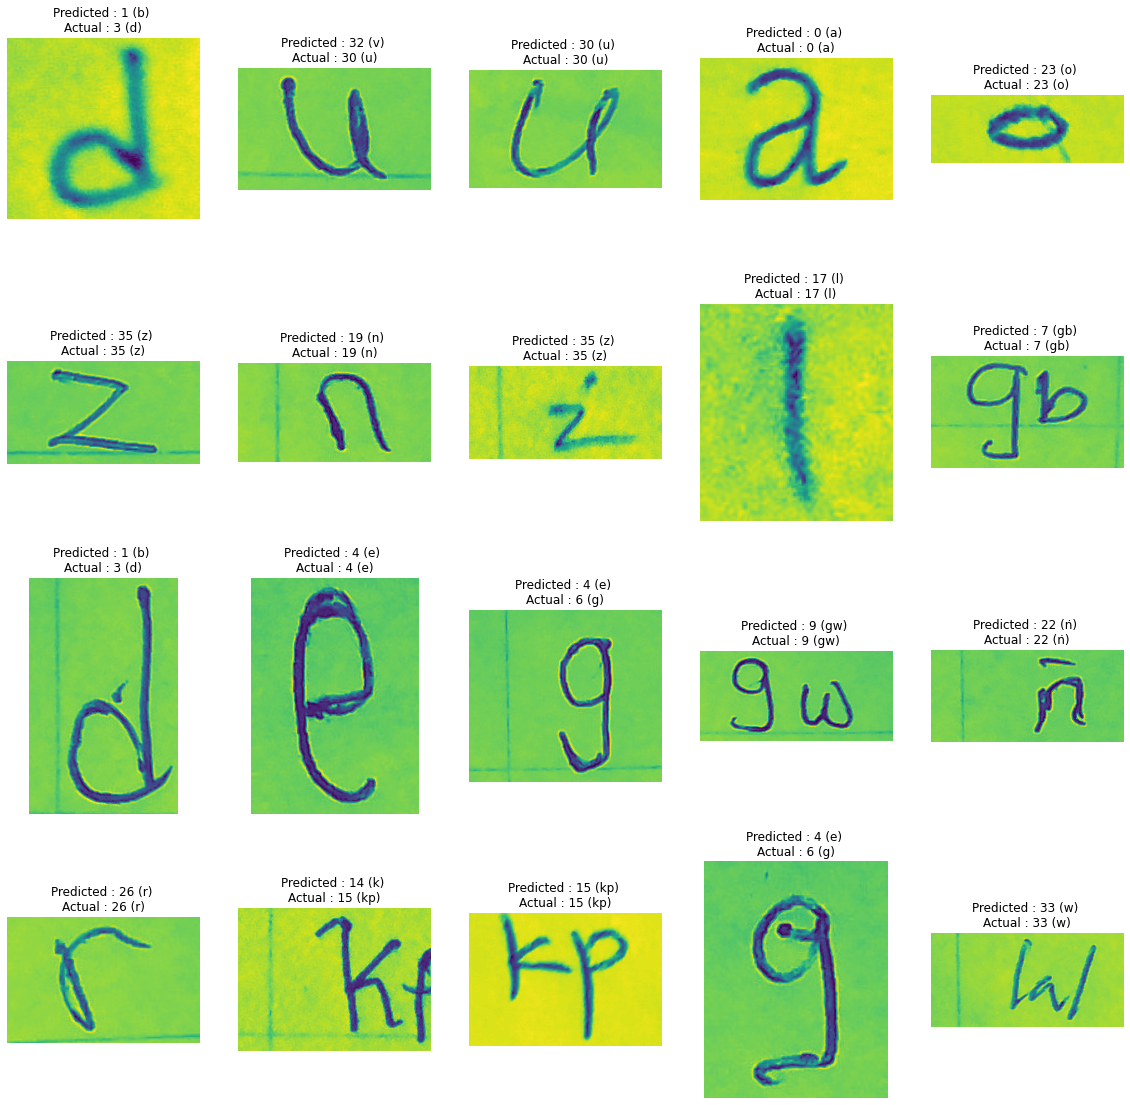

In [ ]:
pred = predict(model1, data=testing_set_aug_images, target_size=(64,64), kind="augumented", limit=20, show=True)
pred = pd.DataFrame(pred)

print(f"\n\t\t\t{80 * '*'}\n")
print("\t\t\t RESULTS (MODEL 1)")
print("\t\t\t -----------------\n")
print(f"\t\t\t Accuracy: \t {np.round(accuracy_score(pred.true_labels, pred.pred_labels), 2) * 100} %")
print(f"\t\t\t Recall: \t {np.round(recall_score(pred.true_labels, pred.pred_labels, average='weighted', zero_division=0), 2) * 100} %")
print(f"\t\t\t Precision: \t {np.round(precision_score(pred.true_labels, pred.pred_labels, average='weighted', zero_division=0), 2) * 100} %")
print(f"\t\t\t F1-score: \t {np.round(f1_score(pred.true_labels, pred.pred_labels, average='weighted'), 2) * 100} %")
print(f"\n\t\t\t{80 * '*'}\n")
print("\n\n")


## Model 2 Evaluations

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '




					MODEL 2 PREDICTIONS
					*******************


			********************************************************************************

			 RESULTS (MODEL 2)
			 -----------------

			 Accuracy: 	 80.0 %
			 Recall: 	 80.0 %
			 Precision: 	 82.0 %
			 F1-score: 	 80.0 %

			********************************************************************************






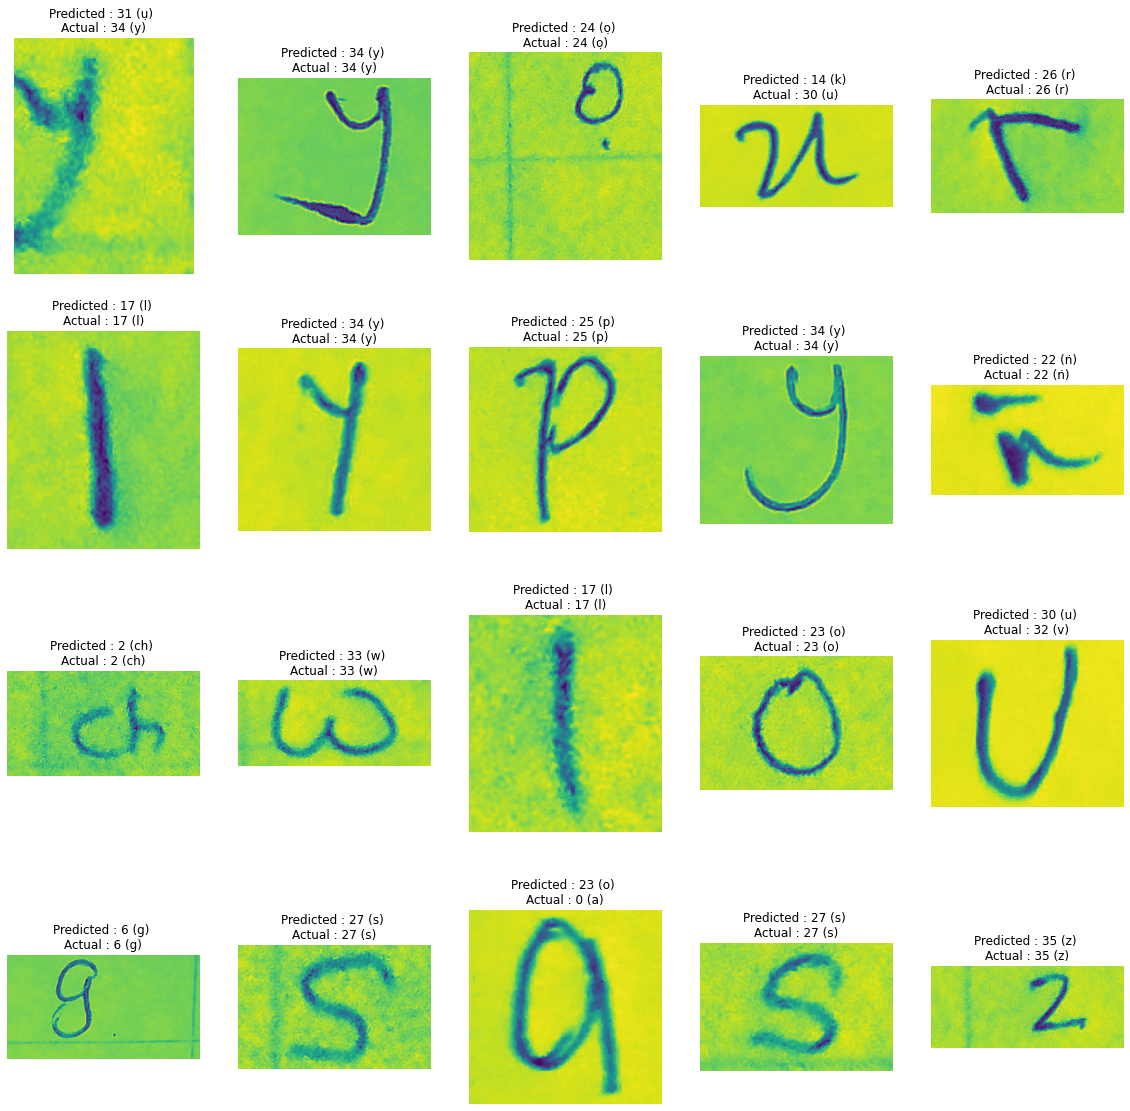

In [ ]:
pred = predict(model2, data=temp_images, target_size=(128,128), kind="multiple", limit=0, show=True)
pred = pd.DataFrame(pred)


print("\n")
print("\t\t\t\t\tMODEL 2 PREDICTIONS")
print("\t\t\t\t\t*******************\n")

print(f"\n\t\t\t{80 * '*'}\n")
print("\t\t\t RESULTS (MODEL 2)")
print("\t\t\t -----------------\n")
print(f"\t\t\t Accuracy: \t {np.round(accuracy_score(pred.true_labels, pred.pred_labels), 2) * 100} %")
print(f"\t\t\t Recall: \t {np.round(recall_score(pred.true_labels, pred.pred_labels, average='weighted', zero_division=0), 2) * 100} %")
print(f"\t\t\t Precision: \t {np.round(precision_score(pred.true_labels, pred.pred_labels, average='weighted', zero_division=0), 2) * 100} %")
print(f"\t\t\t F1-score: \t {np.round(f1_score(pred.true_labels, pred.pred_labels, average='weighted'), 2) * 100} %")
print(f"\n\t\t\t{80 * '*'}\n")
print("\n\n")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '




					MODEL 2 PREDICTIONS
					*******************


			********************************************************************************

			 RESULTS (MODEL 2)
			 -----------------

			 Accuracy: 	 80.0 %
			 Recall: 	 80.0 %
			 Precision: 	 88.0 %
			 F1-score: 	 82.0 %

			********************************************************************************






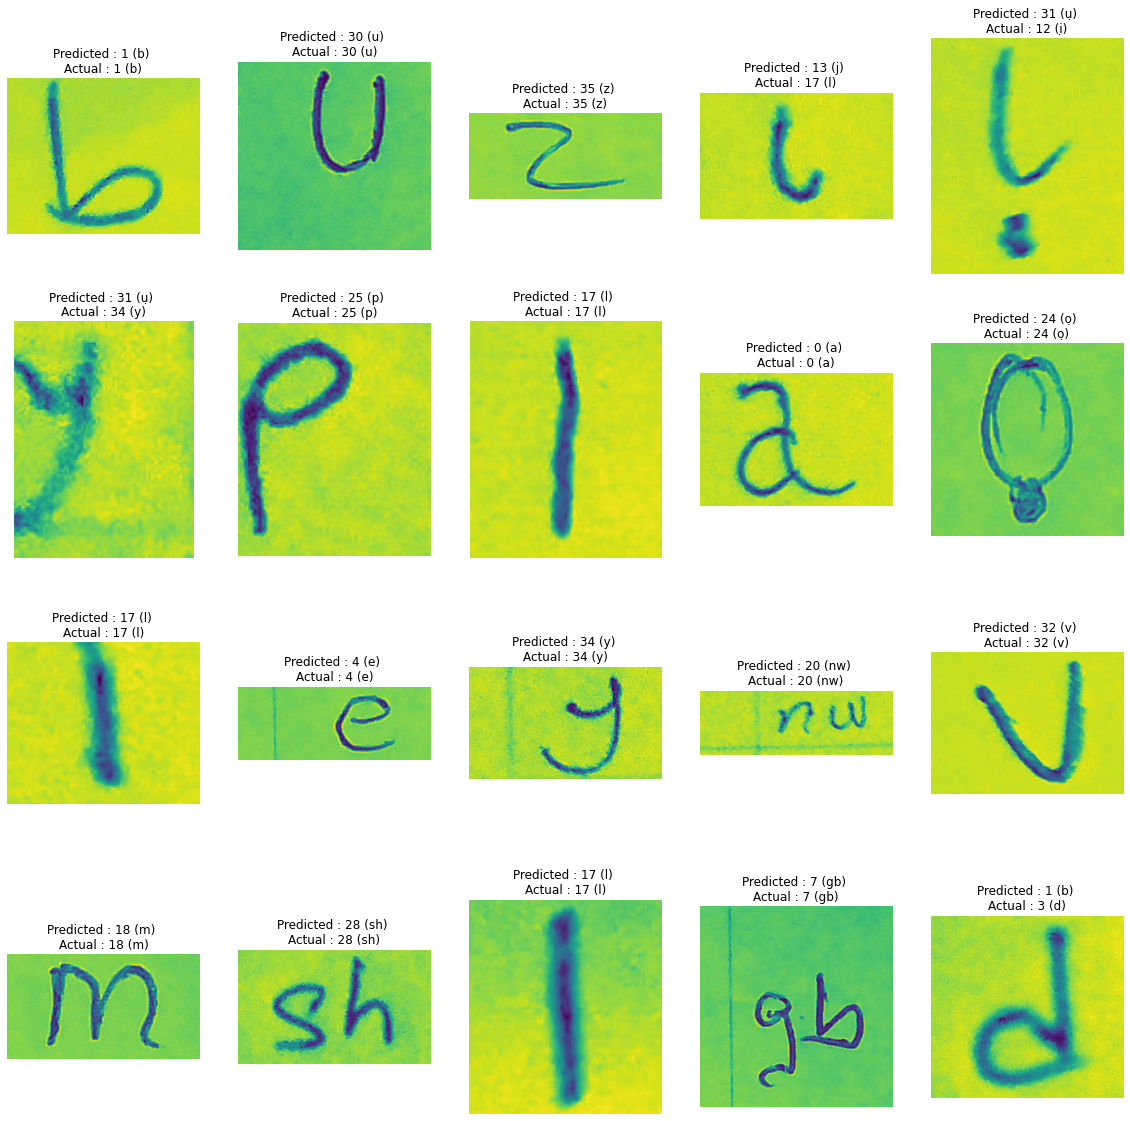

In [ ]:
pred = predict(model2, data=testing_set_aug_images_conf3, target_size=(128,128), kind="augumented", limit=20, show=True)
pred = pd.DataFrame(pred)


print("\n")
print("\t\t\t\t\tMODEL 2 PREDICTIONS")
print("\t\t\t\t\t*******************\n")

print(f"\n\t\t\t{80 * '*'}\n")
print("\t\t\t RESULTS (MODEL 2)")
print("\t\t\t -----------------\n")
print(f"\t\t\t Accuracy: \t {np.round(accuracy_score(pred.true_labels, pred.pred_labels), 2) * 100} %")
print(f"\t\t\t Recall: \t {np.round(recall_score(pred.true_labels, pred.pred_labels, average='weighted', zero_division=0), 2) * 100} %")
print(f"\t\t\t Precision: \t {np.round(precision_score(pred.true_labels, pred.pred_labels, average='weighted', zero_division=0), 2) * 100} %")
print(f"\t\t\t F1-score: \t {np.round(f1_score(pred.true_labels, pred.pred_labels, average='weighted'), 2) * 100} %")
print(f"\n\t\t\t{80 * '*'}\n")
print("\n\n")

# ================= THE END ====================